<img src="support_files/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Python Bootcamp</h1> 
<h3 align="center">August 24-25, 2019, Seattle, WA</h3> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<center><h1>Introduction to xarray</h1></center>

<p>
    <a href="http://xarray.pydata.org/en/stable/">xarray</a> is a library with labelled, n-dimensional data structures. You can think of these data structures like:
<ul>
<li>numpy arrays with labelled axes.
<li>pandas dataframes that can be more than 2-dimensional
</ul>
Using xarray lets you write code that easier to read and harder to misuse. We'll cover a bit of its functionality here, but the xarray project's <a href="http://xarray.pydata.org/en/stable/examples/weather-data.html">the examples</a> and <a href="http://xarray.pydata.org/en/stable/index.html">documentation</a> provide the complete story.

</p>
</div>

In [22]:
import os
import json

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<center><h1>the data</h1></center>
    
<p>
We're going to load up a small dataset of anterograde tract tracing results (from <a href="http://connectivity.brain-map.org/">this project</a>). These are volumes of projection signal, all registered to a common reference space and downsampled to 500-micron isometric resolution.
</p>
</div>

In [23]:
data_path = os.path.join("support_files", "projection_densities.npy")
experiments_path = os.path.join("support_files", "experiment_ids.json")

data = np.load(data_path)
with open(experiments_path, "r") as experiments_file:
    experiments = json.load(experiments_file)

In [24]:
# what experiments do we have?
print(experiments)

[266583498, 161460864, 162018169, 299859225, 518222748, 126116142, 286319739, 267608343, 113766744, 547202505, 560799305, 265136608, 307135126, 298003295, 300237470, 120811946, 267703239, 177889243, 297951732, 485846989, 158257355, 287996596, 182459635, 272968624, 278511717]


In [25]:
# and how many?
print(len(experiments))

25


In [26]:
# what are these data?
print(f"data type: {type(data)}")
print(f"data shape: {data.shape}")

data type: <class 'numpy.ndarray'>
data shape: (25, 26, 16, 23)


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<center><h1>the problem</h1></center>
    
<p>
It's pretty hard to tell what this code does:
</p>

</div>

In [39]:
max_projection = data[13, :, :, :].max(axis=0)

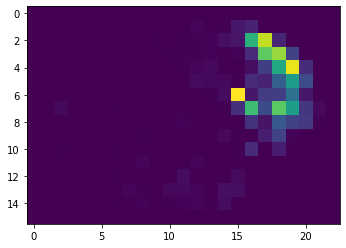

In [40]:
fig, ax = plt.subplots()
ax.imshow(max_projection)
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">    
<p>
The answer goes like this:
    
Our data is a 4d array with the following dimensions:
<ul>
    <li>experiment</li>
    <li>anterior-posterior</li>
    <li>dorsal-ventral</li>
    <li>left-right</li>
</ul>
    
So our code selects the experiment at index 13 (experiment 298003295) and produces a max projection along the anterior-posterior dimension (you can sort of see cortex!).

It is not easy see what this code does by reading it. Also, it is fragile! If some other piece of code changed the order of experiments or dimensions, our snippet would start doing something completely different.

</p>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <center><h1>the xarray <code>DataArray</code></h1></center>

<p> The <code>xarray.DataArray</code> class represents a single n-dimensional array with labels. Its important attributes are:
<ul>
    <li><b>data</b> An underlying <code>numpy.array</code> that actually holds the data</li>
    <li><b>dims</b> Names for each dimension, stored in a tuple</li>
    <li><b>coords</b> A dictionary describing the position at each index in meaningful units</li>
</ul>

We can make a <code>DataArray</code> out of our numpy array by providing some additional information:

</p>
</div>

In [47]:
resolution_step = 500

data_array = xr.DataArray(
    data=data,
    dims=("experiment", "anterior_posterior", "dorsal_ventral", "left_right"),
    coords={
        "experiment": experiments,
        "anterior_posterior": np.arange(data.shape[1]) * resolution_step,
        "dorsal_ventral": np.arange(data.shape[2]) * resolution_step,
        "left_right": np.arange(data.shape[3]) * resolution_step,
    }
)

In [48]:
# let's take a look
data_array

<xarray.DataArray (experiment: 25, anterior_posterior: 26, dorsal_ventral: 16, left_right: 23)>
array([[[[ 1.427220e-27, ...,  6.053609e-43],
         ...,
         [-2.721686e-40, ..., -8.448615e-32]],

        ...,

        [[ 0.000000e+00, ..., -1.571545e-33],
         ...,
         [-2.802597e-45, ..., -7.006492e-45]]],


       ...,


       [[[ 9.809089e-45, ..., -9.528830e-44],
         ...,
         [ 0.000000e+00, ..., -2.942727e-44]],

        ...,

        [[-3.643376e-44, ...,  0.000000e+00],
         ...,
         [ 4.764415e-44, ..., -3.655287e-41]]]], dtype=float32)
Coordinates:
  * experiment          (experiment) int64 266583498 161460864 ... 278511717
  * anterior_posterior  (anterior_posterior) int64 0 500 1000 ... 12000 12500
  * dorsal_ventral      (dorsal_ventral) int64 0 500 1000 ... 6500 7000 7500
  * left_right          (left_right) int64 0 500 1000 1500 ... 10000 10500 11000

In [55]:
# and rewrite our max projection_snippet
max_projection_xr = data_array.loc[{"experiment": 298003295}].max(dim="anterior_posterior")

# this produces:
max_projection_xr

<xarray.DataArray (dorsal_ventral: 16, left_right: 23)>
array([[6.965700e-26, 2.098320e-15, 8.302471e-12, ..., 2.941277e-11,
        3.612269e-15, 6.707731e-25],
       [2.535230e-24, 3.667599e-07, 3.060545e-06, ..., 1.134120e-08,
        1.045940e-10, 3.803884e-21],
       [2.748662e-20, 1.077682e-08, 2.033244e-08, ..., 1.509524e-06,
        6.279043e-10, 1.190489e-22],
       ...,
       [7.142423e-10, 8.628609e-07, 2.061254e-08, ..., 3.139119e-08,
        2.626336e-06, 1.045532e-08],
       [5.599495e-07, 1.224249e-06, 1.981034e-07, ..., 2.181099e-08,
        1.171465e-07, 5.092454e-09],
       [5.304657e-22, 1.217718e-04, 1.162100e-05, ..., 2.612993e-21,
        3.157377e-25, 8.175592e-21]], dtype=float32)
Coordinates:
    experiment      int64 298003295
  * dorsal_ventral  (dorsal_ventral) int64 0 500 1000 1500 ... 6500 7000 7500
  * left_right      (left_right) int64 0 500 1000 1500 ... 10000 10500 11000

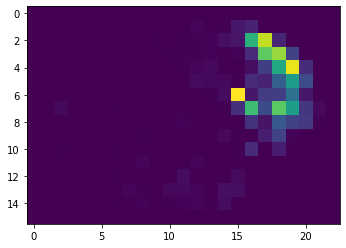

In [54]:
fig, ax = plt.subplots()
ax.imshow(max_projection_xr)
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <center><h1>selecting data</h1></center>

Above we used <code>.loc[{"experiment": 298003295}]</code> to extract data for a single experiment. Commonly we want to do 

</p>
</div>

In [56]:
# we can select on multiple experiments
data_array.loc[{"experiment": [298003295, 177889243]}]

<xarray.DataArray (experiment: 2, anterior_posterior: 26, dorsal_ventral: 16, left_right: 23)>
array([[[[-1.102682e-41, ..., -8.407791e-45],
         ...,
         [ 1.440793e-27, ..., -2.858649e-43]],

        ...,

        [[-2.648566e-32, ..., -1.723267e-34],
         ...,
         [-1.250420e-29, ...,  1.446488e-30]]],


       [[[-1.972011e-35, ...,  0.000000e+00],
         ...,
         [-0.000000e+00, ...,  1.696171e-37]],

        ...,

        [[-2.972785e-24, ..., -9.034757e-39],
         ...,
         [ 7.075450e-40, ...,  1.401298e-45]]]], dtype=float32)
Coordinates:
  * experiment          (experiment) int64 298003295 177889243
  * anterior_posterior  (anterior_posterior) int64 0 500 1000 ... 12000 12500
  * dorsal_ventral      (dorsal_ventral) int64 0 500 1000 ... 6500 7000 7500
  * left_right          (left_right) int64 0 500 1000 1500 ... 10000 10500 11000

In [57]:
# or on multiple dimensions simultaneously
data_array.loc[{
    "experiment": [298003295, 177889243],
    "anterior_posterior": 2000
}]

<xarray.DataArray (experiment: 2, dorsal_ventral: 16, left_right: 23)>
array([[[-5.753792e-30,  3.403639e-29, ..., -5.130423e-15,  6.360052e-32],
        [-1.310686e-26,  2.155300e-11, ...,  4.960527e-18,  6.578841e-35],
        ...,
        [-4.174892e-17, -1.174847e-19, ...,  9.054034e-12, -5.910500e-29],
        [-1.420594e-34, -4.412779e-37, ...,  1.490631e-28,  1.063776e-31]],

       [[-8.772409e-41,  5.079570e-30, ..., -8.511342e-32,  6.465744e-35],
        [ 1.184419e-38,  1.478139e-20, ..., -6.149782e-15, -1.412135e-31],
        ...,
        [-3.685415e-43, -6.495278e-27, ...,  4.186304e-12, -5.759880e-28],
        [-0.000000e+00, -5.380986e-43, ...,  1.089879e-08,  2.010051e-25]]],
      dtype=float32)
Coordinates:
  * experiment          (experiment) int64 298003295 177889243
    anterior_posterior  int64 2000
  * dorsal_ventral      (dorsal_ventral) int64 0 500 1000 ... 6500 7000 7500
  * left_right          (left_right) int64 0 500 1000 1500 ... 10000 10500 11000

In [59]:
# We can also subselect data by conditions
data_array.where(data_array["dorsal_ventral"] > 5000, drop=True)

<xarray.DataArray (experiment: 25, anterior_posterior: 26, dorsal_ventral: 5, left_right: 23)>
array([[[[-2.905573e-33, ...,  9.429528e-39],
         ...,
         [-2.721686e-40, ..., -8.448615e-32]],

        ...,

        [[-1.500397e-34, ..., -0.000000e+00],
         ...,
         [-2.802597e-45, ..., -7.006492e-45]]],


       ...,


       [[[ 0.000000e+00, ...,  3.503667e-41],
         ...,
         [ 0.000000e+00, ..., -2.942727e-44]],

        ...,

        [[-1.506829e-36, ..., -7.717908e-31],
         ...,
         [ 4.764415e-44, ..., -3.655287e-41]]]], dtype=float32)
Coordinates:
  * experiment          (experiment) int64 266583498 161460864 ... 278511717
  * anterior_posterior  (anterior_posterior) int64 0 500 1000 ... 12000 12500
  * dorsal_ventral      (dorsal_ventral) int64 5500 6000 6500 7000 7500
  * left_right          (left_right) int64 0 500 1000 1500 ... 10000 10500 11000